In [1]:
import findspark
findspark.init()

import pyspark
import random

In [2]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, when, count, col

In [3]:
filename = "2004.csv"

In [4]:
def _init_spark():
    spark = SparkSession.builder.appName("Project").getOrCreate()
    sc = spark.sparkContext
    return spark, sc

In [5]:
spark, sc = _init_spark()

In [7]:
sqlContext = SQLContext(sc)

df = sqlContext.read.load(filename, 
                      format='com.databricks.spark.csv', 
                      header='true',
                      delimiter=',',
                      inferSchema='true')
df.cache()

DataFrame[Year: int, Month: int, DayofMonth: int, DayOfWeek: int, DepTime: string, CRSDepTime: int, ArrTime: string, CRSArrTime: int, UniqueCarrier: string, FlightNum: int, TailNum: string, ActualElapsedTime: string, CRSElapsedTime: int, AirTime: string, ArrDelay: string, DepDelay: string, Origin: string, Dest: string, Distance: int, TaxiIn: int, TaxiOut: int, Cancelled: int, CancellationCode: string, Diverted: int, CarrierDelay: int, WeatherDelay: int, NASDelay: int, SecurityDelay: int, LateAircraftDelay: int]

In [8]:
# removing as is stated in the task along with the 'Year'
col_to_drop = ['ArrTime', 'ActualElapsedTime', 'AirTime', 'TaxiIn', 'Diverted', 
               'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Year']
df = df.drop(*col_to_drop)

In [9]:
# "CancelationCode" has too much "null" (98% of the data) we will remove it too. Others have no missing values except for "TailNum", that has only 127 values left.  
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+---------+----------------+
|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiOut|Cancelled|CancellationCode|
+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+---------+----------------+
|    0|         0|        0|      0|         0|         0|            0|        0|    127|             0|       0|       0|     0|   0|       0|      0|        0|         7001506|
+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+---------+----------------+



In [11]:
# deletion of the "CancelationCode" and droping rows that contain "TailNum", "UniqueCarrier" 
# is represented by several values so we will explore it later
df = df.drop('CancellationCode')
df = df.drop('TailNum')
## df = df.filter(df.TailNum.isNotNull() )

In [12]:
df.printSchema()

root
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)



In [13]:
# "ArrDelay" and "DepDelay" have string type. We cast them to Integer
df = df.withColumn("ArrDelay", df["ArrDelay"].cast(IntegerType()))
df = df.withColumn("DepDelay", df["DepDelay"].cast(IntegerType()))
df.printSchema()

root
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)



In [14]:
old_amount = df.count()
df = df.na.drop("any")
new_amount = df.count()
print( "Before: " +str(old_amount) + ",\nAfter: " + str(new_amount) + ",\n%:"+str(round(new_amount/old_amount, 2)*100))

Before: 7129270,
After: 6987729,
%:98.0


In [15]:
df.show(5)

### LIN REG with only numerical values

In [33]:
corr_matrix = df.select([x[0] for x in df.dtypes if 'int' in x])

In [34]:
corr_matrix.show(5)

In [35]:
# I guess it is too pythonic and we nees to change it's PEARSON CORRELATION

[(c[0], df.corr("ArrDelay", c[0])) for c in corr_matrix.dtypes]

[('Month', 0.008202777323020096),
 ('DayofMonth', 0.024984890590987054),
 ('DayOfWeek', -0.017791803836727405),
 ('CRSDepTime', 0.1267987420931976),
 ('CRSArrTime', 0.12408222835628847),
 ('FlightNum', -0.001189494331136067),
 ('CRSElapsedTime', -0.013223108616871579),
 ('ArrDelay', 1.0),
 ('DepDelay', 0.907447881121435),
 ('Distance', -0.013181189620090234),
 ('TaxiOut', 0.25188155159775766),
 ('Cancelled', nan)]

In [36]:
features = df.select(['DepDelay', 'TaxiOut'])

In [37]:
from pyspark.ml.feature import VectorAssembler

In [38]:
assembler = VectorAssembler(
    inputCols=features.columns,
    outputCol="features")

In [ ]:
#df = df.fillna(0, subset=(['DepDelay', 'Cancelled', 'ArrDelay']))

In [39]:
output = assembler.transform(df).select('features','ArrDelay')

In [40]:
output.take(5)

[Row(features=DenseVector([-7.0, 11.0]), ArrDelay=-14),
 Row(features=DenseVector([-9.0, 16.0]), ArrDelay=-4),
 Row(features=DenseVector([3.0, 15.0]), ArrDelay=5),
 Row(features=DenseVector([-3.0, 10.0]), ArrDelay=-16),
 Row(features=DenseVector([5.0, 13.0]), ArrDelay=3)]

In [41]:
train,test = output.randomSplit([0.75, 0.25])

In [42]:
train.show(25)

+--------------+--------+
|      features|ArrDelay|
+--------------+--------+
|     (2,[],[])|     -34|
|     (2,[],[])|     -25|
|     (2,[],[])|     -23|
|     (2,[],[])|     -23|
|     (2,[],[])|     -19|
|     (2,[],[])|     -18|
|     (2,[],[])|     -15|
|     (2,[],[])|     -13|
|     (2,[],[])|     -12|
|     (2,[],[])|     -12|
|     (2,[],[])|     -10|
|     (2,[],[])|      -8|
|     (2,[],[])|      -2|
|     (2,[],[])|      -2|
|     (2,[],[])|      -2|
|     (2,[],[])|      -2|
|     (2,[],[])|       1|
|     (2,[],[])|       5|
|     (2,[],[])|       7|
|     (2,[],[])|      12|
|  [-230.0,5.0]|      -7|
|[-174.0,197.0]|       5|
|  [-50.0,57.0]|      -6|
|  [-50.0,70.0]|       3|
|  [-39.0,15.0]|     -44|
+--------------+--------+
only showing top 25 rows



In [43]:
from pyspark.ml.regression import LinearRegression
lin_reg = LinearRegression(featuresCol = 'features', labelCol='ArrDelay')
linear_model = lin_reg.fit(train)

In [44]:
print("Coefficients: " + str(linear_model.coefficients))
print("\nIntercept: " + str(linear_model.intercept))

Coefficients: [1.0017693299003945,0.42400278832501004]

Intercept: -8.143825807640756


In [45]:
trainSummary = linear_model.summary
print("RMSE: %f" % trainSummary.rootMeanSquaredError)
print("MAE: %f" % trainSummary.meanAbsoluteError ) 
print("\nr2: %f" % trainSummary.r2)

RMSE: 12.421156
MAE: 7.842334

r2: 0.861526


In [ ]:
from  pyspark.sql.functions import abs
predictions = linear_model.transform(test)
x =((predictions['ArrDelay']-predictions['prediction'])/predictions['ArrDelay'])*100
predictions = predictions.withColumn('Accuracy',abs(x))
predictions.select("prediction","ArrDelay","Accuracy","features").show(10)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
pred_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="ArrDelay",metricName="r2")
print("R Squared (R2) on test data = %g" % pred_evaluator.evaluate(predictions))

### Dealing with categorical data

In [16]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler



df1 = df.select('Origin', 'Dest','DepDelay', 'TaxiOut')
cols = df1.columns

categoricalColumns = ['Origin', 'Dest']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]


    
     
label_stringIdx = StringIndexer(inputCol = 'DepDelay', outputCol = 'ArrDelay')
stages += [label_stringIdx]


numericCols = ['DepDelay', 'TaxiOut']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df1)
df1 = pipelineModel.transform(df1)
selectedCols = ['ArrDelay', 'features'] + cols
df1 = df.select(selectedCols)
df1.printSchema()





AnalysisException: cannot resolve '`features`' given input columns: [ArrDelay, CRSArrTime, CRSDepTime, CRSElapsedTime, Cancelled, DayOfWeek, DayofMonth, DepDelay, DepTime, Dest, Distance, FlightNum, Month, Origin, TaxiOut, UniqueCarrier];;
'Project [ArrDelay#929, 'features, Origin#32, Dest#33, DepDelay#946, TaxiOut#36]
+- Filter AtLeastNNulls(n, Month#17,DayofMonth#18,DayOfWeek#19,DepTime#20,CRSDepTime#21,CRSArrTime#23,UniqueCarrier#24,FlightNum#25,CRSElapsedTime#28,ArrDelay#929,DepDelay#946,Origin#32,Dest#33,Distance#34,TaxiOut#36,Cancelled#37)
   +- Project [Month#17, DayofMonth#18, DayOfWeek#19, DepTime#20, CRSDepTime#21, CRSArrTime#23, UniqueCarrier#24, FlightNum#25, CRSElapsedTime#28, ArrDelay#929, cast(DepDelay#31 as int) AS DepDelay#946, Origin#32, Dest#33, Distance#34, TaxiOut#36, Cancelled#37]
      +- Project [Month#17, DayofMonth#18, DayOfWeek#19, DepTime#20, CRSDepTime#21, CRSArrTime#23, UniqueCarrier#24, FlightNum#25, CRSElapsedTime#28, cast(ArrDelay#30 as int) AS ArrDelay#929, DepDelay#31, Origin#32, Dest#33, Distance#34, TaxiOut#36, Cancelled#37]
         +- Project [Month#17, DayofMonth#18, DayOfWeek#19, DepTime#20, CRSDepTime#21, CRSArrTime#23, UniqueCarrier#24, FlightNum#25, CRSElapsedTime#28, ArrDelay#30, DepDelay#31, Origin#32, Dest#33, Distance#34, TaxiOut#36, Cancelled#37]
            +- Project [Month#17, DayofMonth#18, DayOfWeek#19, DepTime#20, CRSDepTime#21, CRSArrTime#23, UniqueCarrier#24, FlightNum#25, TailNum#26, CRSElapsedTime#28, ArrDelay#30, DepDelay#31, Origin#32, Dest#33, Distance#34, TaxiOut#36, Cancelled#37]
               +- Project [Month#17, DayofMonth#18, DayOfWeek#19, DepTime#20, CRSDepTime#21, CRSArrTime#23, UniqueCarrier#24, FlightNum#25, TailNum#26, CRSElapsedTime#28, ArrDelay#30, DepDelay#31, Origin#32, Dest#33, Distance#34, TaxiOut#36, Cancelled#37, CancellationCode#38]
                  +- Relation[Year#16,Month#17,DayofMonth#18,DayOfWeek#19,DepTime#20,CRSDepTime#21,ArrTime#22,CRSArrTime#23,UniqueCarrier#24,FlightNum#25,TailNum#26,ActualElapsedTime#27,CRSElapsedTime#28,AirTime#29,ArrDelay#30,DepDelay#31,Origin#32,Dest#33,Distance#34,TaxiIn#35,TaxiOut#36,Cancelled#37,CancellationCode#38,Diverted#39,... 5 more fields] csv


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

df = spark.createDataFrame([(0, "a", 1), (1, "b", 2), (2, "c", 3), (3, "a", 4), (4, "a", 4), (5, "c", 3)], ["id", "category1", "category2"])

indexer = StringIndexer(inputCol="category1", outputCol="category1Index")
inputs = [indexer.getOutputCol(), "category2"]
encoder = OneHotEncoder(inputCols=inputs, outputCols=["categoryVec1", "categoryVec2"])
pipeline = Pipeline(stages=[indexer, encoder])
pipeline.fit(df).transform(df).show()

In [ ]:
NON_corr_matrix = df.select([x[0] for x in df.dtypes if x[1] !='int'])
NON_corr_matrix.show(5)

In [ ]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler


In [ ]:
origin = NON_corr_matrix.select("Origin").distinct().collect()

In [ ]:
origin[:5]

In [ ]:
from pyspark.ml.feature import StringIndexer

df = sqlContext.createDataFrame(
    [(0, "a"), (1, "b"), (2, "c"), (3, "a"), (4, "a"), (5, "c")],
    ["id", "category"])
indexer = StringIndexer(inputCol="category", outputCol="categoryIndex")
indexed = indexer.fit(df).transform(df)
indexed.show()

### Correlation experiments

In [ ]:
# First approach
# from pyspark.ml.linalg import Vectors
# from pyspark.ml.stat import Correlation

# data = [(Vectors.sparse(4, [(0, 1.0), (3, -2.0)]),),
#         (Vectors.dense([4.0, 5.0, 0.0, 3.0]),),
#         (Vectors.dense([6.0, 7.0, 0.0, 8.0]),),
#         (Vectors.sparse(4, [(0, 9.0), (3, 1.0)]),)]
# df = spark.createDataFrame(data, ["features"])

# r1 = Correlation.corr(df, "features").head()
# print("Pearson correlation matrix:\n" + str(r1[0]))

# r2 = Correlation.corr(df, "features", "spearman").head()
# print("Spearman correlation matrix:\n" + str(r2[0]))

In [ ]:
#Second Approach
# from pyspark.ml.stat import Correlation
# from pyspark.ml.feature import VectorAssembler

# # convert to vector column first
# vector_col = "corr_features"
# assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
# df_vector = assembler.transform(df).select(vector_col)

# # get correlation matrix
# matrix = Correlation.corr(df_vector, vector_col)

In [ ]:
# matrix.collect()[0]["pearson({})".format(vector_col)].values

### Visualization experiments

In [22]:
# in order to visualize data, it has to be transformed in Pandas
#unfortunately, our dataset is too large, therefore we only have to get a sample
# in this case we only get 25% of our data, with no replacement

df_Pandas_25 = df.sample(False, 0.25, 42).toPandas()


In [ ]:
#I will be using Altair for visualization, which accepts only 5000 max observations
#from here we can tell what airports have the longest trips

import altair as alt

alt.Chart(df_Pandas_25.sample(n=5000, random_state=1)).mark_point().encode(
    x='Origin',
    y='Distance',
    color='DayOfWeek',
)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x=df_Pandas_25.Origin,
    y=df_Pandas_25.Distance)

In [ ]:
sc.stop()

In [60]:
#importing all the libraries needed
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



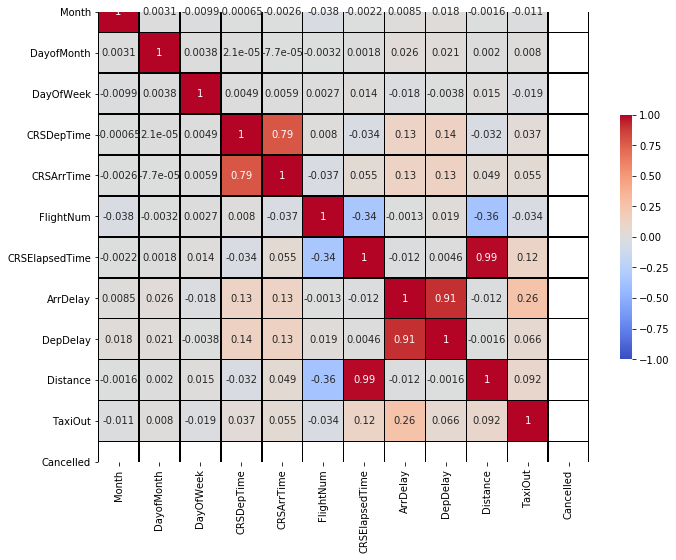

In [68]:
import matplotlib.pyplot as pyplot


fig, ax = plt.subplots(figsize=(11,9))         # Sample figsize in inches

df_pandas = df_Pandas_25.drop(df_Pandas_25.Cancelled)
sns.heatmap(df_pandas.corr(), annot = True, ax=ax,cbar_kws={"shrink": .5},  vmax = 1, vmin = -1, center = 0, cmap='coolwarm', linewidth =.5, linecolor ='black', square = True)
plt.show()

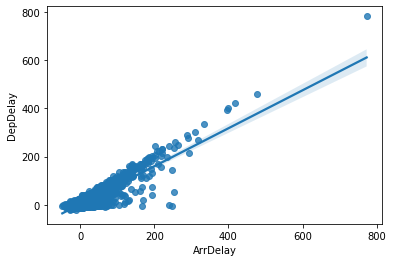

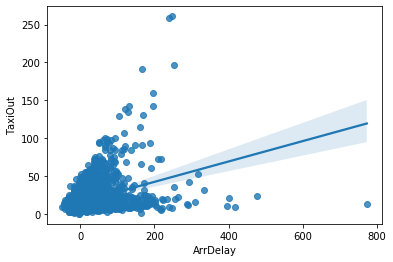

In [88]:
df_Pandas_25s = df.sample(False, 0.001, 42).toPandas()



features = ['DepDelay', 'TaxiOut']
for feature in features:
        sns.regplot(x=df_Pandas_25s["ArrDelay"], y=df_Pandas_25s[feature])
        plt.show(block=False)